Dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

Repositorio github: https://github.com/WilberBarcayaM/SIS421-02-23/tree/main/Laboratorios

## GAN simple

Vamos a ver cómo podemos implementar esta arquitectura y proceso de entrenamiento con la implementación de una *GAN* muy simple para generar imágenes del dataset.

In [1]:
#Subimos tu API key de Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wilberbarc","key":"10f88b754f4b38b10b72dabe8c8d8b52"}'}

In [2]:
#instalamos kaggle y autenticamos para poder decargar
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
# Descargamos el dataset de Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:02<00:00, 182MB/s]
100% 346M/346M [00:02<00:00, 162MB/s]


In [4]:
# Descomprimir el archivo
!unzip intel-image-classification.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mounta

In [5]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
trainset = "/content/seg_train/seg_train"

classes = ("buildings", "forest","glacier", "mountain","sea","street")

In [7]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Define las transformaciones que se aplicarán a las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Forzar a escala de grises con 1 canal
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizar a escala de grises
])

# Carga los datos
data_dir = trainset
dataset = ImageFolder(root=data_dir, transform=transform)

In [8]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(dataset)
len(train)

<ipython-input-8-63fb931c8c78>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)


14034

In [9]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([4096]),
 torch.float32,
 tensor(0.0039, device='cuda:0'),
 tensor(-0.0037, device='cuda:0'))

In [10]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 4096]), torch.Size([32]))

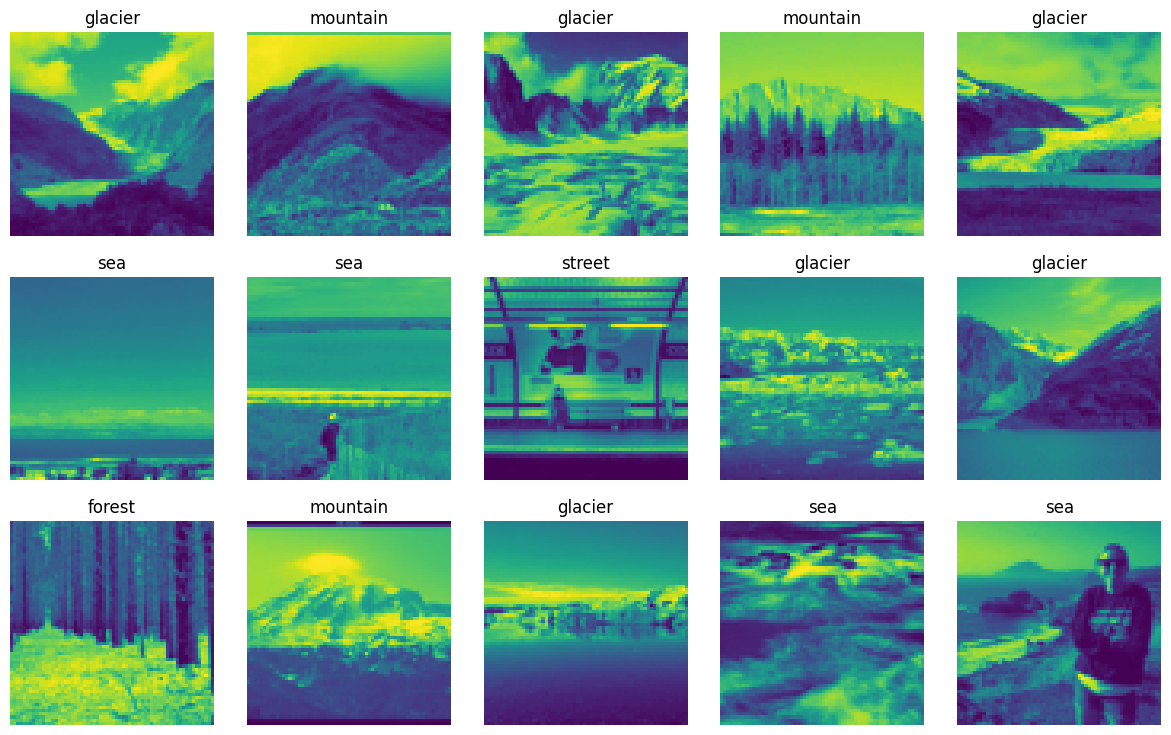

In [11]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(64,64).cpu())
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

 Perceptrón Multicapa (MLP)

In [12]:
import torch.nn as nn

def block(n_in, n_out):
  return nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU(inplace=True)
  )

class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.fc1 = block(input_size, 150)
    self.fc2 = block(150, 100)
    self.fc3 = nn.Linear(100, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [13]:
MLP

__main__.MLP

Nuestro MLP está formado por 3 capas lineales (cada capa seguida de una activación `relu`). En función del número de entradas y salidas definiremos las diferentes redes. Por ejemplo, el generador recibirá un vector con 30 valores aleatorios y nos dará a la salida un vector de 28 x 28 valores (igual que las imágenes del dataset).

In [14]:
n_in, n_out = 30, 64*64
generator = MLP(n_in, n_out)

In [15]:
output = generator(torch.randn(64, 30))
output.shape

torch.Size([64, 4096])

nuestro generador inicializado genera imágenes aleatorias que en nada se parecen a las reales.

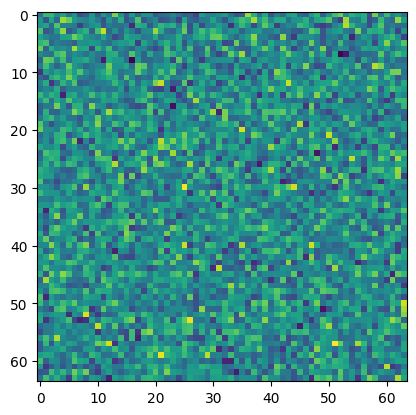

In [16]:
plt.imshow(output[0].reshape(64,64).detach().numpy())
plt.show()

El discriminador, por otro lado, recibirá a la entrada una imagen (100 x 100 valores) y a la salida nos dará una clasificación binaria (real o falso).

In [17]:
discriminator = MLP(64*64, 1)
output = discriminator(torch.randn(64, 64*64))
output.shape

torch.Size([64, 1])

La siguiente función será la responsable de entrenar ambas redes.

In [18]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=60, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:

    for X, y in progress_bar(dataloader, parent=mb):
      #X, y = X.to(device), y.to(device)
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [19]:
hist = fit(generator, discriminator, dataloader)

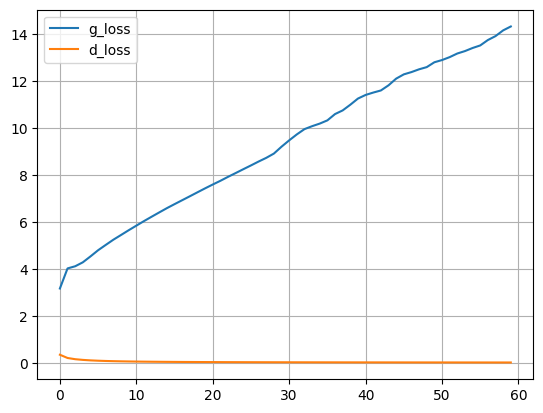

In [20]:
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

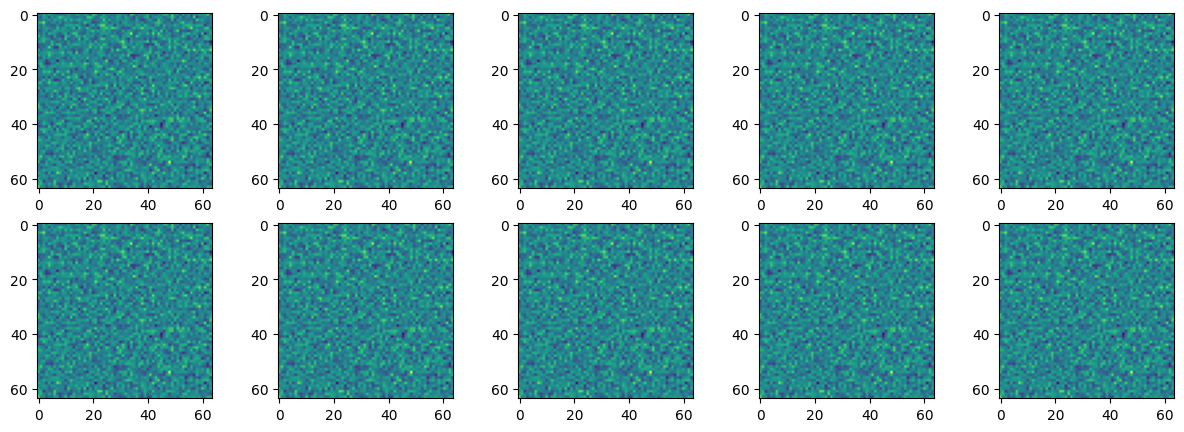

In [21]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(64,64).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

## DCGANs

Podemos usar *DCGANs* (*deep convolutional GANs*) para obtener mejores generadores utilizando redes convolucionales. En este caso, necesitaremos arquitecturas diferentes para generador y discriminador.

In [152]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 100
    self.inp = nn.Sequential(
        nn.Linear(self.input_size,4 * 4 * 256),
        nn.BatchNorm1d(4 * 4 * 256),
    )
    self.main = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1, bias=False),  # Cambié a 64 canales
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.inp(x)
    x = x.view(-1, 256, 4, 4)
    x = self.main(x)
    x = x.view(x.size(0), 64 * 64)
    return x

In [153]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 4096])

Al final del generador usamos una activación `tanh`, que dará valores entre -1 y 1. Por este motivo tenemos que re-normalizar nuestras imágenes en el dataset.

In [154]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(dataset)
len(train)

14034

In [155]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([4096]),
 torch.float32,
 tensor(-0.9922, device='cuda:0'),
 tensor(-1.0074, device='cuda:0'))

In [156]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 4096]), torch.Size([32]))

En cuanto al discriminador, utilizaremos una `CNN` típica como las que conocemos cuando hacemos clasificación de imagen.

In [167]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )
    self.out = nn.Sequential(
        nn.Linear(256*4*4, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # esperamos vectores a la entrada de 64*64
    x = x.view(x.size(0), 1, 64, 64)
    x = self.main(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x

In [168]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 64*64))
output.shape

torch.Size([64, 1])

Ahora podemos utilizar exactamente el mismo bucle de entrenamiento anterior para obtener un nuevo generador.

In [169]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

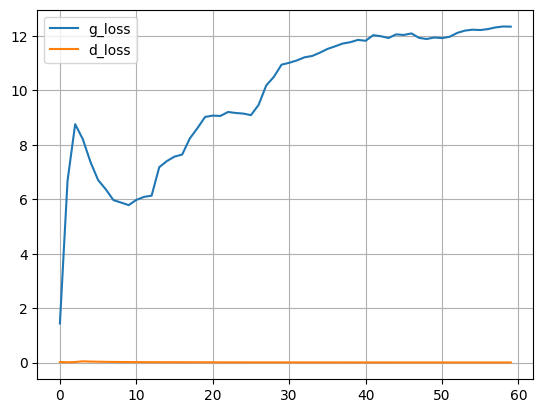

In [170]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

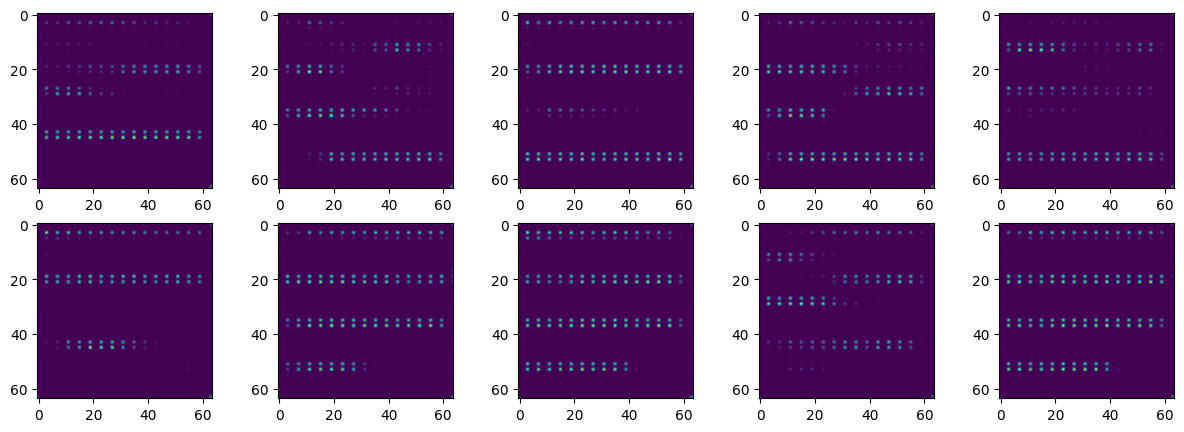

In [172]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(64,64).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()